In [1]:
from fastai.vision.all import *

In [2]:
# download imgs of pets from fast.ai datasets
# this notation is unique for fastai
path = untar_data(URLs.PETS)/'images' # IT RETURNS PATH OBJECT NOT STRING!!!! (BETTER APPROACH)

In [3]:
print('Imgs Location: ', path)
get_image_files(path)

Imgs Location:  C:\Users\vlad\.fastai\data\oxford-iiit-pet\images


(#7390) [Path('C:/Users/vlad/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),Path('C:/Users/vlad/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),Path('C:/Users/vlad/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),Path('C:/Users/vlad/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),Path('C:/Users/vlad/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg'),Path('C:/Users/vlad/.fastai/data/oxford-iiit-pet/images/Abyssinian_103.jpg'),Path('C:/Users/vlad/.fastai/data/oxford-iiit-pet/images/Abyssinian_104.jpg'),Path('C:/Users/vlad/.fastai/data/oxford-iiit-pet/images/Abyssinian_105.jpg'),Path('C:/Users/vlad/.fastai/data/oxford-iiit-pet/images/Abyssinian_106.jpg'),Path('C:/Users/vlad/.fastai/data/oxford-iiit-pet/images/Abyssinian_107.jpg')...]

- We have 7390 different images of cats and dogs (different breed)

In [5]:
def is_cat(x): 
    return x[0].isupper()

dls = ImageDataLoaders.from_name_func(
    path=path,
    fnames=get_image_files(path),
    valid_pct=0.2,
    seed=42,
    label_func=is_cat,
    shuffle=True,
    item_tfms=Resize(224)
)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


- The first part of the class name will generally be the type of data you have, such as image or text.
- `item_tfms:` apply transformation to each item 
- `batch_tfms`: apply transformation to each batch 

### Why 224 pixels size?
This is the standard size for historical reasons (old pretrained models require this size exactly). If you increase the size, you’ll often get a model with better results (since it will be able to focus on more details), but at the price of speed and memory consumption.

### Pet Dataset
Includes images of dogs and cats, consisting of 37 breeds. Each image is labeled using its filename: 
- for instance, the file `great_pyrenees_173.jpg` is the 173rd example of an image of a `Great Pyrenees` breed dog in the dataset.

The filenames start with an **uppercase letter if the image is a cat, and a lowercase letter otherwise.**

`from_name_func` means that name of the classes are got using a function (`is_cat` in our case)

It is easy to create a model that does a great job at making predictions on the exact data it has been trained on, but it is much harder to make accurate predictions on data the model has never seen before. **Always pay attention to overfitting.**

However, you should use those methods **only after you have confirmed that overfitting is occurring.** We **often see practitioners using overfitting avoidance techniques even when they have enough data that they didn’t need to do so,** ending up with a model that may be less accurate than what they could have achieved.

In [7]:
# Model definition
resnet_model = vision_learner(
    dls,
    resnet34,
    metrics=error_rate
)

# Model training (transfer learning)
resnet_model.fine_tune(epochs=2)

epoch,train_loss,valid_loss,error_rate,time
0,0.122691,0.019664,0.005413,01:50


epoch,train_loss,valid_loss,error_rate,time
0,0.065115,0.055434,0.017591,01:55
1,0.034528,0.020015,0.006766,01:57


Most of the time, however, **picking an architecture isn’t a very important** part of the deep learning process. In practice it is unlikely to be something you need to spend much time on. **There are some standard architectures that work most of the time.**

- `ResNet34` is both fast and accurate. 34 refers to the number of layers (there are 18, 50, 101, 152)

### Loss and Metric. What is the difference?
- Loss for a optimization algorithm
- Metric for people

### Pretrained Models 
Pretrained models have the weigths that have already been trained by experts to recognize a thousand different
categories across 1.3 million photos (using the famous `ImageNet` dataset). You should **nearly always use a pretrained model** (already very capable)

### Transfer Learning 
Training pretrained models for the own taks. **The last layer is replaced with one or more new layers with randomized weights**,
of an appropriate size for the dataset you are working with. **This last part of the model is known as the head.** Transfer learning allows:
- Train models faster
- Less data 
- More accurate results 

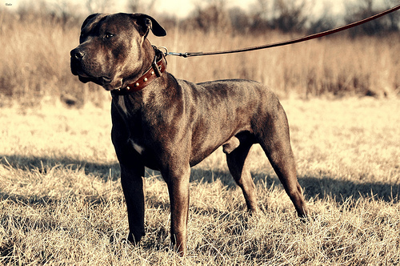

In [25]:
# show img 
f_name = 'american_pit_bull_terrier_4.jpg'
img = PILImage.create(path/f_name)
img.to_thumb(400)

In [14]:
# classify img 
is_cat, _, probs = resnet_model.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: False.
Probability it's a cat: 0.000000


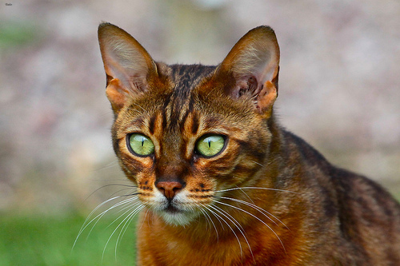

In [27]:
# classify another img
f_name = 'Bengal_14.jpg'
img = PILImage.create(path/f_name)
img.to_thumb(400)

In [29]:
# classify img 
is_cat, _, probs = resnet_model.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: True.
Probability it's a cat: 1.000000


### Non-Image Task Can be Tackled by CV Models 
- Sound: spectogram
- Fraud Detection: users’ mouse movements pics

### Image Segmentation
Localizing images for autonomous vehicles is important. 

`Segmentation` - ability to recognize the content of every individual pixel in an image

In [30]:
path = untar_data(URLs.CAMVID_TINY)

dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames=get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes=np.loadtxt(path/'codes.txt', dtype=str)
)

res_net_model = unet_learner(dls, resnet34)
res_net_model.fine_tune(8)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,time
0,2.763050,2.382489,00:03


epoch,train_loss,valid_loss,time
0,1.798379,1.531766,00:03
1,1.523049,1.490592,00:03
2,1.401915,1.198488,00:03
3,1.245802,1.001699,00:03
4,1.108748,0.926879,00:03
5,0.999012,0.877291,00:03
6,0.910770,0.872751,00:03
7,0.840165,0.854964,00:03


We can visualize how well it achieved its task by asking the model to color-code each
pixel of an image.

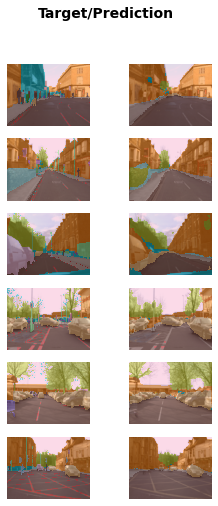

In [39]:
res_net_model.show_results(max_n=6, figsize=(4,8))

### NLP Tasks 
Let's train a model that can classify the sentiment of a movie review.

**Libraries Issues**

- A problem with `typer` may apper, use: `type==0.4.1`. 
- If the dls is not created, delete `\imdb_tok`

**CUDA Run out of Memory**
- Find good batch size

In [2]:
from fastai.text.all import *
import gc

# CUDA memory issue
torch.cuda.empty_cache()

In [1]:
# print(torch.cuda.memory_summary(device=None, abbreviated=None))

In [3]:
dls = TextDataLoaders.from_folder(
    path=untar_data(URLs.IMDB),
    train='train',
    valid='test', # validation data is called test in the target folder
    seq_len=54, 
    shuffle=True,
    bs=16,
    seed=42
)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [6]:
# # Internet connection is needed!!! (CUDA Error!)
# lstm_model = text_classifier_learner(
#     dls=dls,
#     arch=AWD_LSTM,
#     seq_len=54,
#     pretrained=True,
#     drop_mult=0.5,
#     lr=0.001
# )

# lstm_model.fine_tune(
#     epochs=1,
#     base_lr=1e-2
# )

In [7]:
# Test the model 
comment_1 = 'I really liked that movie!'
comment_2 = 'Not recommended!!!'

In [8]:
# # test the model
# learn.predict(comment_1)

### Tabular Data

In [9]:
from fastai.tabular.all import *

In [10]:
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(
    path/'adult.csv', path=path, y_names="salary",
    cat_names = [
        'workclass', 'education', 'marital-status', 
        'occupation','relationship', 'race'
    ],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize]
)
learn = tabular_learner(dls, metrics=accuracy)

Use `fit_one_cycle`, the most commonly used method for training fastai models from scratch (i.e., without transfer learning)

In [11]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.385828,0.356135,0.838145,00:05
1,0.351749,0.346659,0.837991,00:05
2,0.355153,0.338330,0.842445,00:05


### RecSys 

In [12]:
from fastai.collab import *

In [13]:
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.512399,1.399718,00:00


epoch,train_loss,valid_loss,time
0,1.357906,1.338315,00:00
1,1.248142,1.153812,00:00
2,1.025313,0.844614,00:00
3,0.807407,0.693886,00:00
4,0.701176,0.653730,00:00
5,0.652445,0.638023,00:00
6,0.629157,0.630547,00:00
7,0.612272,0.627604,00:00
8,0.613817,0.625972,00:00
9,0.606781,0.625830,00:00


Although we’re not actually using a pretrained model (for the same reason that we didn’t for the tabular model), this example shows that fastai lets us use `fine_tune` anyway in this case. 

Sometimes it’s best to experiment with `fine_tune` versus `fit_one_cycle` to see which works best for your dataset.

### Validation and Test Data
- Validation and Test data must not contain the same examples 
- Huperparameters tuning leads to overfitting to validation data (thus test data must be created)
- Test data should not be used to improve the model, it must be used only at the very end of our efforts (no model tuning)
- Test and Validation data must have enough size (accurate estimate of the performance)
- Test and Validation data must be representative of the new data you will see in the future
- Always check the quality of train/validation/test data. Some questions to answer:
    - How many different observations we have (different people, breed, car brands)?
    - Does the same observation present in validation/test data?
    - How many similar observations we have in train/validation/test data?
    - Are there observations that model may overfit?
    
    